# Know your Data

First, let's get familiar with the problem and the data. The data is good if it accomplishes its intended task. There are many characteristics we should monitor for in features (missing values, distributions, leaking labels, ranges, skew, outliers). Here for inspection and visual appearance, I'm using `Facets` tool. Below are the screenshots and the code to reproduce them.

![Numeric features](files/overview_num.png "Numeric Features")

![Categorical Features](files/overview_cat.png "Categorical Features")

## Whole dataset

#### num_adults

Has a few zero values that can be easily set to `1`. Has not a long tail that probably can be clipped to a maximum of `6`.

#### num_children

Mostly consist of `0`. When building a simple model could be simplified to a boolean feature.

#### ts and ts_date

Cumulative distribution is a bit curved so some days get more searches. Time period `2017-04-18 04:41:09 - 2017-05-02 04:06:34` `2 weeks`. `Mean` of queries per day `3133` and `2986` standart deviation.

![Search dates](files/overview_dates.png "Search dates")

#### event_type

This is the column to derive the target label. Where a user books or not. `book` to `search` proportion is `1/25`.

#### user_id

A bit less linear than `ts` showing signs of a fraction of more active users. With `32k` unique users and `1.5` searches per user (`1.186` standart deviation).

#### date_from

The cumulative distribution is curved showing more popular dates queried within the provided period.

#### date_to

Less curved than `date_from`

#### origin

The cumulative distribution suggests some popular origins and a tail of less popular ones. `20` airports cover `~92%` of the dataset.

#### destination

Destinations are more diverse with `120` airports covering `~93%` of the data.

## Bookings subset

Bookings-only subset of data goes more or less aligned with general dynamics. Users who booked are unique. From and To dates show existance of popular chooses. Origin and destination airports as well show popular chooses especially for origin.

Now it is intresting to see searches in dynamics groupped by users. That reveals time span behavior and can show how  booking events develop.

#### Booking groups

Groups of records where users do a booking amount for `9490` rows (`~ 20%` of the dataset). There, as expected, users do more searches with mean `4.310325` and `1.693763` standart deviation. `~23` bookings somehow got no searches (outliers?). Despite uneven distribution of searches over dates booking groups are distributed more even. Other fields distributions seem similar. Some booking groups are mixed with regular search sessions so additional fitering is needed to split data into time sessions. Proportion of users to users that booked is `1800 / 31000 = ~5 %` 

![Search bookings dates](files/overview_booking_dates.png "Search bookings dates")

For spliting into booking sessions a time gap of `120 min` between events was derived to cover the most of valid sessions. Splitting into sessions has shown users doing a several sessions without bookings. Total number of booking sessions is `1666` with mean `3.182473` and std `1.778167` searches per session.

# Next [Data processing]

Next I will fix minor data inconsistency and introduce new derived fields in a separate notebook.

[**Data processing**](transform.ipynb)

Below you can explore the dataset yourself.

In [1]:
import pandas as pd

features = [
    "ts", "event_type", "user_id", "date_from",
    "date_to", "origin", "destination", "num_adults",
    "num_children"
]

df = pd.read_csv("../task/events_1_1.csv", skiprows=1, names=features)
df.insert(loc=0, column='ts_date', value=pd.to_datetime(df['ts'], infer_datetime_format=True).dt.date)
df_booked = df[df['event_type'] == 'book']

In [2]:
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
import base64

# Prepare data for Facets
gfsg = GenericFeatureStatisticsGenerator()
proto = gfsg.ProtoFromDataFrames([{'name': 'all', 'table': df}, {'name': 'booked', 'table': df_booked}])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")

In [3]:
# Display the facets overview visualization for this data
from IPython.core.display import display, HTML

HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

In [5]:
df.groupby('ts_date').size().describe()

count      15.000000
mean     3133.800000
std      2986.023902
min       580.000000
25%       773.500000
50%      1346.000000
75%      4717.500000
max      8650.000000
dtype: float64

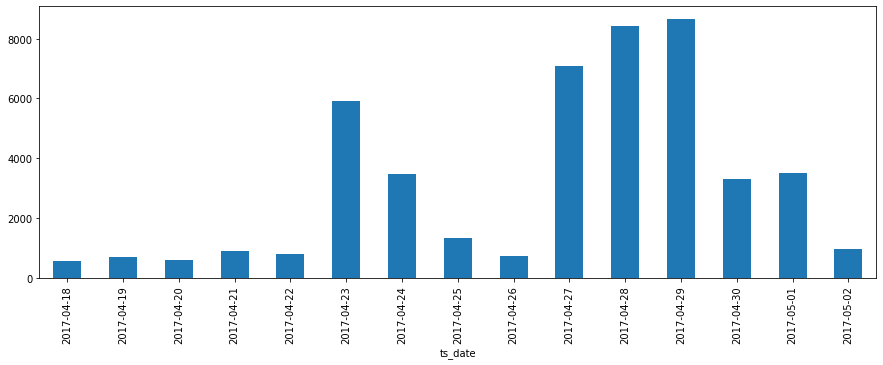

In [6]:
df.groupby('ts_date').size().plot.bar(figsize=(15,5))

In [7]:
df.groupby('user_id').size().describe()

count    31179.000000
mean         1.507649
std          1.186055
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         25.000000
dtype: float64

In [8]:
# user groups ended with bookings
book_df = df[df['user_id'].isin(df[df['event_type'] == 'book']['user_id'])]

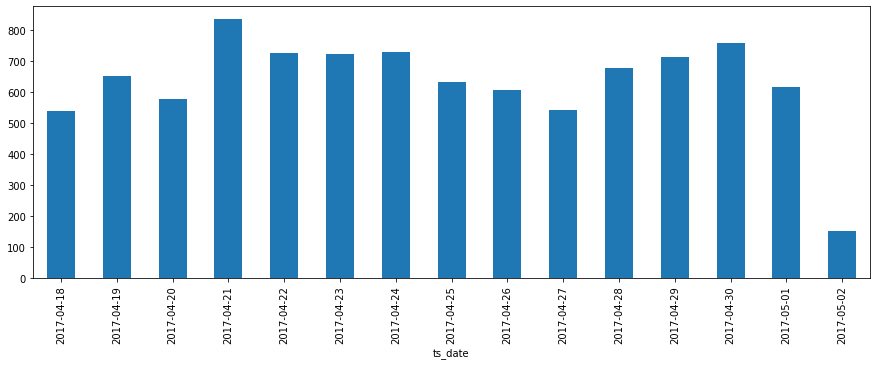

In [9]:
book_df.groupby('ts_date').size().plot.bar(figsize=(15,5))

In [10]:
# searches per user wihtin users who booked
book_df[book_df['event_type'] == 'search'].groupby('user_id').size().describe()

count    1782.000000
mean        4.310325
std         1.693763
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        13.000000
dtype: float64

In [11]:
#
# Lets observe some groups where people booked. For that we sort the data by user_id, ts
#

book_df = book_df.sort_values(by=['user_id','ts'])
book_df[:10]

,ts_date,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children
5959,2017-04-24,2017-04-24 02:20:28,search,0035d4,2018-02-08,2018-02-20,DUS,AGP,2,0
6442,2017-04-24,2017-04-24 02:29:04,search,0035d4,2018-02-08,2018-02-20,DUS,AGP,2,0
334,2017-04-28,2017-04-28 04:26:21,search,0035d4,2018-02-08,2018-02-20,DUS,AGP,3,1
10026,2017-04-28,2017-04-28 04:46:36,search,0035d4,2018-02-08,2018-02-20,DUS,AGP,3,1
7575,2017-04-28,2017-04-28 05:09:25,search,0035d4,2018-02-08,2018-02-20,DUS,AGP,3,1
8461,2017-04-29,2017-04-29 03:20:11,search,0035d4,2018-02-08,2018-02-20,DUS,AGP,3,1
6428,2017-04-29,2017-04-29 03:33:59,search,0035d4,2018-02-08,2018-02-20,DUS,AGP,3,1
177,2017-04-29,2017-04-29 03:43:29,search,0035d4,2018-02-08,2018-02-20,DUS,AGP,3,1
8401,2017-04-29,2017-04-29 03:48:22,book,0035d4,2018-02-08,2018-02-20,DUS,AGP,3,1
8138,2017-04-24,2017-04-24 14:53:29,search,004671,2017-05-14,2017-05-15,DUS,MUC,1,0


In [12]:
proto_booked = gfsg.ProtoFromDataFrames([{'name': 'booked_sessions', 'table': book_df}])
protostr_booked = base64.b64encode(proto_booked.SerializeToString()).decode("utf-8")


html_booked = HTML_TEMPLATE.format(protostr=protostr_booked)

# uncomment to see booked sessions statistics.
# display(HTML(html_booked))

In [13]:
#
# Lets derive reliable search sessions with bookings. Following the condition 
# we split the data into sessions:
# 
# (time diff since the last query is > N min) OR (user changes) OR (booking event happens)
#
# For that we would need to lear the gap size
#

time_diff = pd.to_datetime(book_df['ts'], infer_datetime_format=True).diff()
book_event_map = book_df.event_type == 'book'

time_diff.loc[book_event_map[book_event_map == True].index].quantile([.8,.9,.91,.92,.93,.94,.95,.96])

0.80   00:24:55.800000
0.90   00:43:03.200000
0.91   00:48:23.639999
0.92   00:54:25.080000
0.93   01:13:17.080000
0.94   01:56:34.360000
0.95   04:52:58.799999
0.96   09:18:11.039999
Name: ts, dtype: timedelta64[ns]

In [14]:
#
# 94% of bookings happen within two hours since the last search. Lets take this value.
# Above go outliers (double bookings) that we will split into separate sessions.
#

gt_120min = time_diff > pd.Timedelta(minutes=120)
diff_user = book_df.user_id != book_df.user_id.shift()
diff_event = book_df.event_type.shift() == 'book'


book_df['session_id'] = (diff_user | gt_120min | diff_event).cumsum()
# book_df[20:30]
book_df

,ts_date,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,session_id
5959,2017-04-24,2017-04-24 02:20:28,search,0035d4,2018-02-08,2018-02-20,DUS,AGP,2,0,1
6442,2017-04-24,2017-04-24 02:29:04,search,0035d4,2018-02-08,2018-02-20,DUS,AGP,2,0,1
334,2017-04-28,2017-04-28 04:26:21,search,0035d4,2018-02-08,2018-02-20,DUS,AGP,3,1,2
10026,2017-04-28,2017-04-28 04:46:36,search,0035d4,2018-02-08,2018-02-20,DUS,AGP,3,1,2
7575,2017-04-28,2017-04-28 05:09:25,search,0035d4,2018-02-08,2018-02-20,DUS,AGP,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...
4709,2017-04-21,2017-04-21 01:29:02,search,ffd667,2017-08-16,2017-08-25,HAM,MXP,3,0,3216
4710,2017-04-21,2017-04-21 01:29:02,search,ffd667,2017-08-16,2017-08-25,HAM,MXP,3,0,3216
5327,2017-04-21,2017-04-21 01:29:02,search,ffd667,2017-08-16,2017-08-25,HAM,MXP,3,0,3216
5329,2017-04-21,2017-04-21 01:30:12,search,ffd667,2017-08-16,2017-08-25,HAM,MXP,3,0,3216


In [15]:
# finaly user booking sessions
book_sess_df = book_df[book_df['session_id'].isin(book_df[book_df['event_type'] == 'book']['session_id'])]
book_sess_df

,ts_date,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,session_id
8461,2017-04-29,2017-04-29 03:20:11,search,0035d4,2018-02-08,2018-02-20,DUS,AGP,3,1,3
6428,2017-04-29,2017-04-29 03:33:59,search,0035d4,2018-02-08,2018-02-20,DUS,AGP,3,1,3
177,2017-04-29,2017-04-29 03:43:29,search,0035d4,2018-02-08,2018-02-20,DUS,AGP,3,1,3
8401,2017-04-29,2017-04-29 03:48:22,book,0035d4,2018-02-08,2018-02-20,DUS,AGP,3,1,3
8138,2017-04-24,2017-04-24 14:53:29,search,004671,2017-05-14,2017-05-15,DUS,MUC,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...
4709,2017-04-21,2017-04-21 01:29:02,search,ffd667,2017-08-16,2017-08-25,HAM,MXP,3,0,3216
4710,2017-04-21,2017-04-21 01:29:02,search,ffd667,2017-08-16,2017-08-25,HAM,MXP,3,0,3216
5327,2017-04-21,2017-04-21 01:29:02,search,ffd667,2017-08-16,2017-08-25,HAM,MXP,3,0,3216
5329,2017-04-21,2017-04-21 01:30:12,search,ffd667,2017-08-16,2017-08-25,HAM,MXP,3,0,3216


In [16]:
# searches per session wihtin sessions who booked
book_sess_df[book_sess_df['event_type'] == 'search'].groupby('user_id').size().describe()

count    1666.000000
mean        3.182473
std         1.778167
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         9.000000
dtype: float64